In [1]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 1.7 MB/s eta 0:00:00


In [2]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from enum import Enum
import cv2
from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
import gc
from tensorflow.keras.utils import to_categorical
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/MURA-v1.1.zip

Streaming output truncated to the last 5000 lines.
   creating: MURA-v1.1/train/XR_SHOULDER/patient01061/
   creating: MURA-v1.1/train/XR_SHOULDER/patient01061/study1_positive/
  inflating: MURA-v1.1/train/XR_SHOULDER/patient01061/study1_positive/image1.png  
  inflating: MURA-v1.1/train/XR_SHOULDER/patient01061/study1_positive/image3.png  
  inflating: MURA-v1.1/train/XR_SHOULDER/patient01061/study1_positive/image2.png  
   creating: MURA-v1.1/train/XR_SHOULDER/patient01016/
   creating: MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/
  inflating: MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/image1.png  
  inflating: MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/image3.png  
  inflating: MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/image2.png  
   creating: MURA-v1.1/train/XR_SHOULDER/patient01182/
   creating: MURA-v1.1/train/XR_SHOULDER/patient01182/study1_positive/
  inflating: MURA-v1.1/train/XR_SHOULDER/patient01182/study1_positive/ima

In [5]:
import os
path = '/content/MURA-v1.1/train'
os.listdir(path)

['XR_ELBOW',
 'XR_HUMERUS',
 'XR_HAND',
 'XR_WRIST',
 'XR_FINGER',
 'XR_FOREARM',
 'XR_SHOULDER']

In [6]:
def load_path(path):
    
    '''
    load MURA dataset
    '''
    dataset = [] 
    for body in os.listdir(path):
        body_part = body
        path_p = path+'/'+str(body)
        for id_p in os.listdir(path_p):
            patient_id = id_p
            path_id = path_p+'/'+str(id_p)
            for lab in os.listdir(path_id):
                if lab.split('_')[-1]=='positive': 
                    label = 1 
                elif lab.split('_')[-1]=='negative':
                    label= 0
                path_l = path_id+'/'+str(lab)
                for img in os.listdir(path_l):  
                    img_path = path_l + '/' + str(img)
                    dataset.append(
                        {
                            'body_part': body_part,
                            'patient_id': patient_id,
                            'label': label,
                            'img_path': img_path
                        }
                    )
    return dataset

In [7]:
dataset = load_path(path)
df_train = pd.DataFrame(dataset)
df_train.head()

,body_part,patient_id,label,img_path
0,XR_ELBOW,patient05171,1,/content/MURA-v1.1/train/XR_ELBOW/patient05171...
1,XR_ELBOW,patient05171,1,/content/MURA-v1.1/train/XR_ELBOW/patient05171...
2,XR_ELBOW,patient05171,1,/content/MURA-v1.1/train/XR_ELBOW/patient05171...
3,XR_ELBOW,patient05171,1,/content/MURA-v1.1/train/XR_ELBOW/patient05171...
4,XR_ELBOW,patient05164,1,/content/MURA-v1.1/train/XR_ELBOW/patient05164...


In [8]:
path = '/content/MURA-v1.1/valid'
os.listdir(path)

['XR_ELBOW',
 'XR_HUMERUS',
 'XR_HAND',
 'XR_WRIST',
 'XR_FINGER',
 'XR_FOREARM',
 'XR_SHOULDER']

In [9]:
dataset = load_path(path)
df_valid = pd.DataFrame(dataset)
df_valid.head()

,body_part,patient_id,label,img_path
0,XR_ELBOW,patient11421,1,/content/MURA-v1.1/valid/XR_ELBOW/patient11421...
1,XR_ELBOW,patient11421,1,/content/MURA-v1.1/valid/XR_ELBOW/patient11421...
2,XR_ELBOW,patient11421,1,/content/MURA-v1.1/valid/XR_ELBOW/patient11421...
3,XR_ELBOW,patient11421,1,/content/MURA-v1.1/valid/XR_ELBOW/patient11421...
4,XR_ELBOW,patient11856,0,/content/MURA-v1.1/valid/XR_ELBOW/patient11856...


In [10]:

def random_rotation_flip(image,size = 256):
    if random.randint(0,1):
        image = cv2.flip(image,1) # 1-->horizontal flip 0-->Vertical flip -1-->Horizontal and vertical

    if random.randint(0,1):
            angle = random.randint(-30,30)
            M = cv2.getRotationMatrix2D((size/2,size/2),angle,1)
            #The third parameter: the size of the transformed image
            image = cv2.warpAffine(image,M,(size,size))
    return image

In [11]:
def image_loader(Path, size = 224): 
    Images = []
    for path in tqdm(Path):
        try:
            image = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image,(size,size))
            image = random_rotation_flip(image,size)
            Images.append(image)
        except Exception as e:
            print(str(e))   
    Images = np.asarray(Images).astype('float32')
    mean = np.mean(Images)
    std = np.std(Images)
    Images = (Images - mean) / std
    
    return Images

In [12]:
im_size = 256

In [13]:
X_train = image_loader(df_train['img_path'][:50,],im_size)

100%|██████████| 50/50 [00:00<00:00, 233.58it/s]


In [14]:
X_train

array([[[-1.3058790e+00, -1.3058790e+00, -1.3058790e+00, ...,
         -1.3058790e+00, -1.3058790e+00, -1.3058790e+00],
        [-1.3058790e+00, -1.3058790e+00, -1.3058790e+00, ...,
         -1.3058790e+00, -1.3058790e+00, -1.3058790e+00],
        [-1.3058790e+00, -1.3058790e+00, -1.3058790e+00, ...,
         -1.3058790e+00, -1.3058790e+00, -1.3058790e+00],
        ...,
        [-1.3058790e+00, -1.3058790e+00, -1.3058790e+00, ...,
         -1.3058790e+00, -1.3058790e+00, -1.3058790e+00],
        [-1.3058790e+00, -1.3058790e+00, -1.3058790e+00, ...,
         -1.3058790e+00, -1.3058790e+00, -1.3058790e+00],
        [-1.3058790e+00, -1.3058790e+00, -1.3058790e+00, ...,
         -1.3058790e+00, -1.3058790e+00, -1.3058790e+00]],

       [[-1.3058790e+00, -1.3058790e+00, -1.3058790e+00, ...,
         -1.3058790e+00, -1.3058790e+00, -1.3058790e+00],
        [-1.3058790e+00, -1.3058790e+00, -1.3058790e+00, ...,
         -1.3058790e+00, -1.3058790e+00, -1.3058790e+00],
        [-1.3058790e+00, 

In [15]:
y_train = df_train['label']

In [16]:
y_train

0        1
1        1
2        1
3        1
4        1
        ..
36807    0
36808    0
36809    0
36810    0
36811    0
Name: label, Length: 36812, dtype: int64

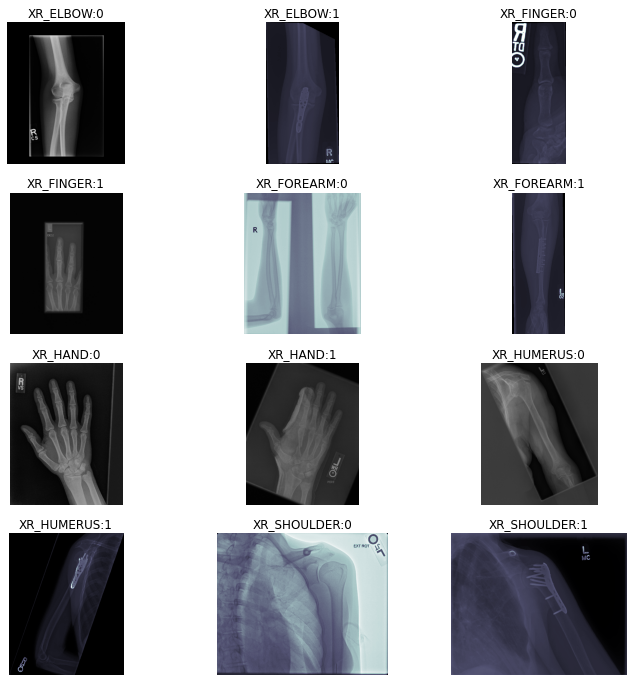

In [17]:
from skimage.io import imread
sub_df = df_train.groupby(['body_part', 'label']).apply(lambda x: x.sample(1)).reset_index(drop = True)
fig, (m_axs) = plt.subplots(4, sub_df.shape[0]//4, figsize = (12, 12))
for c_ax, (_, c_row) in zip(m_axs.flatten(), sub_df.iterrows()):
    c_ax.imshow(imread(c_row['img_path']), cmap = 'bone')
    c_ax.axis('off')
    c_ax.set_title('{body_part}:{label}'.format(**c_row))

In [18]:
from sklearn.model_selection import train_test_split
valid, test = train_test_split(df_valid, test_size=0.2)

In [19]:
valid

,body_part,patient_id,label,img_path
531,XR_HUMERUS,patient11690,0,/content/MURA-v1.1/valid/XR_HUMERUS/patient116...
2114,XR_FINGER,patient11896,1,/content/MURA-v1.1/valid/XR_FINGER/patient1189...
338,XR_ELBOW,patient11819,1,/content/MURA-v1.1/valid/XR_ELBOW/patient11819...
1317,XR_WRIST,patient11310,0,/content/MURA-v1.1/valid/XR_WRIST/patient11310...
2943,XR_SHOULDER,patient11186,1,/content/MURA-v1.1/valid/XR_SHOULDER/patient11...
...,...,...,...,...
651,XR_HUMERUS,patient11646,1,/content/MURA-v1.1/valid/XR_HUMERUS/patient116...
8,XR_ELBOW,patient11821,1,/content/MURA-v1.1/valid/XR_ELBOW/patient11821...
2254,XR_FINGER,patient11288,1,/content/MURA-v1.1/valid/XR_FINGER/patient1128...
1652,XR_WRIST,patient11247,1,/content/MURA-v1.1/valid/XR_WRIST/patient11247...


In [20]:
test

,body_part,patient_id,label,img_path
2420,XR_FOREARM,patient11425,1,/content/MURA-v1.1/valid/XR_FOREARM/patient114...
1202,XR_HAND,patient11592,0,/content/MURA-v1.1/valid/XR_HAND/patient11592/...
1915,XR_FINGER,patient11910,1,/content/MURA-v1.1/valid/XR_FINGER/patient1191...
1329,XR_WRIST,patient11303,0,/content/MURA-v1.1/valid/XR_WRIST/patient11303...
688,XR_HUMERUS,patient11640,1,/content/MURA-v1.1/valid/XR_HUMERUS/patient116...
...,...,...,...,...
2963,XR_SHOULDER,patient11707,1,/content/MURA-v1.1/valid/XR_SHOULDER/patient11...
544,XR_HUMERUS,patient11628,1,/content/MURA-v1.1/valid/XR_HUMERUS/patient116...
592,XR_HUMERUS,patient11556,1,/content/MURA-v1.1/valid/XR_HUMERUS/patient115...
756,XR_HAND,patient11365,0,/content/MURA-v1.1/valid/XR_HAND/patient11365/...


In [21]:
X_valid = image_loader(valid['img_path'][:50,],im_size)

100%|██████████| 50/50 [00:00<00:00, 351.54it/s]


In [22]:
X_valid

array([[[-1.0873971 , -1.0873971 , -1.0873971 , ..., -1.0873971 ,
         -1.0873971 , -1.0873971 ],
        [-1.0873971 , -1.0873971 , -1.0873971 , ..., -1.0873971 ,
         -1.0873971 , -1.0873971 ],
        [-1.0873971 , -1.0873971 , -1.0873971 , ..., -1.0873971 ,
         -1.0873971 , -1.0873971 ],
        ...,
        [-1.0873971 , -1.0873971 , -1.0873971 , ..., -1.0873971 ,
         -1.0873971 , -1.0873971 ],
        [-1.0873971 , -1.0873971 , -1.0873971 , ..., -1.0873971 ,
         -1.0873971 , -1.0873971 ],
        [-1.0873971 , -1.0873971 , -1.0873971 , ..., -1.0873971 ,
         -1.0873971 , -1.0873971 ]],

       [[-1.0873971 , -1.0873971 , -1.0873971 , ..., -1.0873971 ,
         -1.0873971 , -1.0873971 ],
        [-1.0873971 , -1.0873971 , -1.0873971 , ..., -1.0873971 ,
         -1.0873971 , -1.0873971 ],
        [-1.0873971 , -1.0873971 , -1.0873971 , ..., -1.0873971 ,
         -1.0873971 , -1.0873971 ],
        ...,
        [-1.0873971 , -1.0873971 , -1.0873971 , ..., -

In [23]:
y_valid = valid['label']

In [24]:
y_valid

531     0
2114    1
338     1
1317    0
2943    1
       ..
651     1
8       1
2254    1
1652    1
2125    0
Name: label, Length: 2557, dtype: int64

In [25]:
X_test = image_loader(test['img_path'][:50,],im_size)

100%|██████████| 50/50 [00:00<00:00, 337.87it/s]


In [26]:
y_test = test['label']

In [27]:
y_test

2420    1
1202    0
1915    1
1329    0
688     1
       ..
2963    1
544     1
592     1
756     0
2442    0
Name: label, Length: 640, dtype: int64

In [28]:
image_generator_settings = dict(
                          rescale = 1. / 255,
                          #samplewise_center = True,
                          #samplewise_std_normalization = True
                          #rotation_range = 5, 
                         )
image_generator = ImageDataGenerator(**image_generator_settings)


In [29]:
#Image Generator
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [30]:
df_train

,body_part,patient_id,label,img_path
0,XR_ELBOW,patient05171,1,/content/MURA-v1.1/train/XR_ELBOW/patient05171...
1,XR_ELBOW,patient05171,1,/content/MURA-v1.1/train/XR_ELBOW/patient05171...
2,XR_ELBOW,patient05171,1,/content/MURA-v1.1/train/XR_ELBOW/patient05171...
3,XR_ELBOW,patient05171,1,/content/MURA-v1.1/train/XR_ELBOW/patient05171...
4,XR_ELBOW,patient05164,1,/content/MURA-v1.1/train/XR_ELBOW/patient05164...
...,...,...,...,...
36807,XR_SHOULDER,patient01540,0,/content/MURA-v1.1/train/XR_SHOULDER/patient01...
36808,XR_SHOULDER,patient01540,0,/content/MURA-v1.1/train/XR_SHOULDER/patient01...
36809,XR_SHOULDER,patient01903,0,/content/MURA-v1.1/train/XR_SHOULDER/patient01...
36810,XR_SHOULDER,patient01903,0,/content/MURA-v1.1/train/XR_SHOULDER/patient01...


In [31]:
import PIL
import os
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path("/content/MURA-v1.1/train").rglob("*.png")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            os.remove(img_p)
            print(img_p)

/content/MURA-v1.1/train/XR_WRIST/patient07840/study1_negative/._image1.png
/content/MURA-v1.1/train/XR_WRIST/patient07840/study2_negative/._image2.png
/content/MURA-v1.1/train/XR_WRIST/patient07840/study2_negative/._image1.png
/content/MURA-v1.1/train/XR_WRIST/patient07840/study2_negative/._image3.png


In [32]:
train_generator = image_generator.flow_from_dataframe(dataframe = df_train,directory = None,x_col = 'img_path',y_col = 'label',batch_size = 64,shuffle = True,class_mode = 'raw', target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest')
valid_generator = image_generator.flow_from_dataframe(dataframe = valid,directory = None,x_col = 'img_path',y_col = 'label',batch_size = 64,shuffle = True,class_mode = 'raw',target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest')
test_generator = image_generator.flow_from_dataframe(dataframe = test,directory = None,x_col = 'img_path',y_col = 'label',batch_size = 64,shuffle = False,class_mode = 'raw', target_size = (im_size, im_size),color_mode = 'rgb',interpolation='nearest')

Found 36808 validated image filenames.
Found 2557 validated image filenames.
Found 640 validated image filenames.


/usr/local/lib/python3.9/dist-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 4 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(


In [33]:
# Build model
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Convolution2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(im_size, im_size, 3), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3, 3), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

model.summary()

model.compile(loss='SparseCategoricalCrossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

#Train
model.fit_generator(train_generator,
                    steps_per_epoch=len(df_train) // 64,
                    epochs=1,
                    validation_data=valid_generator,
                    validation_steps=len(valid) // 64)

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(test_generator, len(test) // 64+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.labels, y_pred))
print('Classification Report')
print(classification_report(test_generator.labels, y_pred))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 activation (Activation)     (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 125, 125, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                    

<ipython-input-33-a213cf9d1fc7>:33: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator,


KeyboardInterrupt: ignored

In [ ]:
model_mobile_netV3Large=tf.keras.applications.MobileNetV3Large(
    input_shape=(im_size, im_size, 3),
    alpha=1.0,
    minimalistic=False,
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    classes=2,
    pooling=None,
    dropout_rate=0.2,
    classifier_activation='softmax',
    include_preprocessing=True
)

#adding the flatten and sigmoid layers
model_mobile_netV3Large = tf.keras.models.Sequential([
    model_mobile_netV3Large,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

model_mobile_netV3Large.summary()

model_mobile_netV3Large.compile(loss='SparseCategoricalCrossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

#Train
model_mobile_netV3Large.fit_generator(train_generator,
                    steps_per_epoch=len(df_train) // 64,
                    epochs=5,
                    validation_data=valid_generator,
                    validation_steps=len(valid) // 64)

#Confution Matrix and Classification Report
Y_pred_Mv3Large = model_mobile_netV3Large.predict_generator(test_generator, len(test) // 64+1)
y_pred_Mv3Large = np.argmax(Y_pred_Mv3Large, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.labels, y_pred_Mv3Large))
print('Classification Report')
print(classification_report(test_generator.labels, y_pred_Mv3Large))


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 8, 8, 960)        2996352   
 l)                                                              
                                                                 
 flatten_2 (Flatten)         (None, 61440)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                3932224   
                                                                 
 activation_2 (Activation)   (None, 64)                0         
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                      

<ipython-input-43-6d450c686386>:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_mobile_netV3Large.fit_generator(train_generator,


Epoch 1/5
575/575 [==============================] - 264s 423ms/step - loss: 0.6814 - accuracy: 0.6970 - val_loss: 1.7800 - val_accuracy: 0.5284
Epoch 2/5
575/575 [==============================] - 241s 418ms/step - loss: 0.5125 - accuracy: 0.7755 - val_loss: 1.3656 - val_accuracy: 0.5276
Epoch 3/5
575/575 [==============================] - 242s 420ms/step - loss: 0.4697 - accuracy: 0.7971 - val_loss: 1.2447 - val_accuracy: 0.5296
Epoch 4/5
575/575 [==============================] - 238s 413ms/step - loss: 0.4412 - accuracy: 0.8142 - val_loss: 432.9630 - val_accuracy: 0.5308
Epoch 5/5
575/575 [==============================] - 243s 422ms/step - loss: 0.4130 - accuracy: 0.8264 - val_loss: 9059.0166 - val_accuracy: 0.5296


<ipython-input-43-6d450c686386>:39: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred_Mv3Large = model_mobile_netV3Large.predict_generator(test_generator, len(test) // 64+1)


Confusion Matrix
[[316   0]
 [324   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       316
           1       0.00      0.00      0.00       324

    accuracy                           0.49       640
   macro avg       0.25      0.50      0.33       640
weighted avg       0.24      0.49      0.33       640



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
from sklearn.metrics import classification_report, confusion_matrix

In [35]:
model_mobile_irnv2=tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    input_shape=(im_size, im_size, 3),
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    classes=2,
    pooling=None,
    classifier_activation='softmax'
)

#adding the flatten and sigmoid layers
model_mobile_irnv2 = tf.keras.models.Sequential([
    model_mobile_irnv2,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

model_mobile_irnv2.summary()
model_mobile_irnv2.compile(loss='SparseCategoricalCrossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

#Train
model_mobile_irnv2.fit_generator(train_generator,
                    steps_per_epoch=len(df_train) // 64,
                    epochs=50,
                    validation_data=valid_generator,
                    validation_steps=len(valid) // 64)

#Confution Matrix and Classification Report
Y_pred_irnv2 = model_mobile_irnv2.predict_generator(test_generator, len(test) // 64+1)
y_pred_irnv2 = np.argmax(Y_pred_irnv2, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.labels, y_pred_irnv2))
print('Classification Report')
print(classification_report(test_generator.labels, y_pred_irnv2))


219055592/219055592 [==============================] - 10s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 55296)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                3539008   
                                                                 
 activation_208 (Activation)  (None, 64)               0         
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 2)              

<ipython-input-35-cbb5230d6495>:27: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_mobile_irnv2.fit_generator(train_generator,


Epoch 1/50
575/575 [==============================] - 958s 2s/step - loss: 0.7036 - accuracy: 0.6770 - val_loss: 0.6006 - val_accuracy: 0.7264
Epoch 2/50
575/575 [==============================] - 890s 2s/step - loss: 0.5184 - accuracy: 0.7665 - val_loss: 0.5774 - val_accuracy: 0.7256
Epoch 3/50
575/575 [==============================] - 892s 2s/step - loss: 0.4920 - accuracy: 0.7824 - val_loss: 0.8977 - val_accuracy: 0.6611
Epoch 4/50
575/575 [==============================] - 892s 2s/step - loss: 0.4639 - accuracy: 0.8008 - val_loss: 0.5072 - val_accuracy: 0.7676
Epoch 5/50
575/575 [==============================] - 890s 2s/step - loss: 0.4349 - accuracy: 0.8174 - val_loss: 0.6206 - val_accuracy: 0.7107
Epoch 6/50
575/575 [==============================] - 892s 2s/step - loss: 0.4054 - accuracy: 0.8304 - val_loss: 0.5051 - val_accuracy: 0.7897
Epoch 7/50
575/575 [==============================] - 893s 2s/step - loss: 0.3784 - accuracy: 0.8452 - val_loss: 0.5417 - val_accuracy: 0.7608

<ipython-input-35-cbb5230d6495>:34: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred_irnv2 = model_mobile_irnv2.predict_generator(test_generator, len(test) // 64+1)


Confusion Matrix
[[260  67]
 [ 72 241]]
Classification Report
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       327
           1       0.78      0.77      0.78       313

    accuracy                           0.78       640
   macro avg       0.78      0.78      0.78       640
weighted avg       0.78      0.78      0.78       640



In [ ]:
model_mobile_iv3=tf.keras.applications.inception_v3.InceptionV3(
    input_shape=(im_size, im_size, 3),
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    classes=2,
    pooling=None,
    classifier_activation='softmax'
)

#adding the flatten and sigmoid layers
model_mobile_iv3 = tf.keras.models.Sequential([
    model_mobile_iv3,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

model_mobile_iv3.summary()
model_mobile_iv3.compile(loss='SparseCategoricalCrossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

#Train
model_mobile_iv3.fit_generator(train_generator,
                    steps_per_epoch=len(df_train) // 64,
                    epochs=5,
                    validation_data=valid_generator,
                    validation_steps=len(valid) // 64)

#Confution Matrix and Classification Report
Y_pred_iv3 = model_mobile_iv3.predict_generator(test_generator, len(test) // 64+1)
y_pred_iv3 = np.argmax(Y_pred_iv3, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.labels, y_pred_iv3))
print('Classification Report')
print(classification_report(test_generator.labels, y_pred_iv3))


87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_13 (Flatten)        (None, 73728)             0         
                                                                 
 dense_25 (Dense)            (None, 64)                4718656   
                                                                 
 activation_332 (Activation)  (None, 64)               0         
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 2)                 130       
                                                      

<ipython-input-57-789019635ecb>:27: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_mobile_iv3.fit_generator(train_generator,


Epoch 1/2
575/575 [==============================] - 437s 709ms/step - loss: 0.8514 - accuracy: 0.5937 - val_loss: 0.7056 - val_accuracy: 0.5160
Epoch 2/2
575/575 [==============================] - 385s 669ms/step - loss: 0.6747 - accuracy: 0.5976 - val_loss: 0.6934 - val_accuracy: 0.5349


<ipython-input-57-789019635ecb>:34: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred_iv3 = model_mobile_iv3.predict_generator(test_generator, len(test) // 64+1)


Confusion Matrix
[[340   3]
 [270  27]]
Classification Report
              precision    recall  f1-score   support

           0       0.56      0.99      0.71       343
           1       0.90      0.09      0.17       297

    accuracy                           0.57       640
   macro avg       0.73      0.54      0.44       640
weighted avg       0.72      0.57      0.46       640



In [ ]:
model_mobile_mv2=tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(im_size, im_size, 3),
    include_top=False,
    weights='imagenet',
    input_tensor=None,

    classes=2,
    pooling=None,
    classifier_activation='softmax'
)

#adding the flatten and sigmoid layers
model_mobile_mv2 = tf.keras.models.Sequential([
    model_mobile_mv2,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

model_mobile_mv2.summary()
model_mobile_mv2.compile(loss='SparseCategoricalCrossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

#Train
model_mobile_mv2.fit_generator(train_generator,
                    steps_per_epoch=len(df_train) // 64,
                    epochs=5,
                    validation_data=valid_generator,
                    validation_steps=len(valid) // 64)

#Confution Matrix and Classification Report
Y_pred_mv2 = model_mobile_mv2.predict_generator(test_generator, len(test) // 64+1)
y_pred_mv2 = np.argmax(Y_pred_mv2, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.labels, y_pred_mv2))
print('Classification Report')
print(classification_report(test_generator.labels, y_pred_mv2))


9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_14 (Flatten)        (None, 81920)             0         
                                                                 
 dense_27 (Dense)            (None, 64)                5242944   
                                                                 
 activation_333 (Activation)  (None, 64)               0         
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_28 (Dense)            (None, 2)                 1

<ipython-input-58-4b6d6e5791fc>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_mobile_mv2.fit_generator(train_generator,


Epoch 1/2
575/575 [==============================] - 337s 545ms/step - loss: 0.8836 - accuracy: 0.5932 - val_loss: 0.7010 - val_accuracy: 0.5164
Epoch 2/2
575/575 [==============================] - 277s 482ms/step - loss: 0.6723 - accuracy: 0.5954 - val_loss: 0.8971 - val_accuracy: 0.5365


<ipython-input-58-4b6d6e5791fc>:35: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred_mv2 = model_mobile_mv2.predict_generator(test_generator, len(test) // 64+1)


Confusion Matrix
[[281  62]
 [212  85]]
Classification Report
              precision    recall  f1-score   support

           0       0.57      0.82      0.67       343
           1       0.58      0.29      0.38       297

    accuracy                           0.57       640
   macro avg       0.57      0.55      0.53       640
weighted avg       0.57      0.57      0.54       640



In [ ]:
model_mobile_res50=tf.keras.applications.resnet50.ResNet50(
    input_shape=(im_size, im_size, 3),
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    classes=2,
    pooling=None,
    classifier_activation='softmax'
)

#adding the flatten and sigmoid layers
model_mobile_res50 = tf.keras.models.Sequential([
    model_mobile_res50,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

model_mobile_res50.summary()
model_mobile_res50.compile(loss='SparseCategoricalCrossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

#Train
model_mobile_res50.fit_generator(train_generator,
                    steps_per_epoch=len(df_train) // 64,
                    epochs=5,
                    validation_data=valid_generator,
                    validation_steps=len(valid) // 64)

#Confution Matrix and Classification Report
Y_pred_res50 = model_mobile_res50.predict_generator(test_generator, len(test) // 64+1)
y_pred_res50 = np.argmax(Y_pred_res50, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.labels, y_pred_res50))
print('Classification Report')
print(classification_report(test_generator.labels, y_pred_res50))


94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_15 (Flatten)        (None, 131072)            0         
                                                                 
 dense_29 (Dense)            (None, 64)                8388672   
                                                                 
 activation_334 (Activation)  (None, 64)               0         
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_30 (Dense)            (None, 2)                 130       
                                                      

<ipython-input-59-e3f175ac08a6>:27: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_mobile_res50.fit_generator(train_generator,


Epoch 1/2
575/575 [==============================] - 516s 843ms/step - loss: 0.9227 - accuracy: 0.5926 - val_loss: 0.7071 - val_accuracy: 0.5160
Epoch 2/2
575/575 [==============================] - 474s 824ms/step - loss: 0.6761 - accuracy: 0.5970 - val_loss: 0.7063 - val_accuracy: 0.5204


<ipython-input-59-e3f175ac08a6>:34: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred_res50 = model_mobile_res50.predict_generator(test_generator, len(test) // 64+1)


Confusion Matrix
[[343   0]
 [297   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.54      1.00      0.70       343
           1       0.00      0.00      0.00       297

    accuracy                           0.54       640
   macro avg       0.27      0.50      0.35       640
weighted avg       0.29      0.54      0.37       640



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_mobile_vgg16=tf.keras.applications.vgg16.VGG16(
    input_shape=(im_size, im_size, 3),
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    
    classes=2,
    pooling=None,
    classifier_activation='softmax'
)

#adding the flatten and sigmoid layers
model_mobile_vgg16 = tf.keras.models.Sequential([
    model_mobile_vgg16,
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(64),
    #tf.keras.layers.Activation('relu'),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

model_mobile_vgg16.summary()
model_mobile_vgg16.compile(loss='SparseCategoricalCrossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

#Train
model_mobile_vgg16.fit_generator(train_generator,
                    steps_per_epoch=len(df_train) // 64,
                    epochs=5,
                    validation_data=valid_generator,
                    validation_steps=len(valid) // 64)

#Confution Matrix and Classification Report
Y_pred_vgg16 = model_mobile_vgg16.predict_generator(test_generator, len(test) // 64+1)
y_pred_vgg16 = np.argmax(Y_pred_vgg16, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.labels, y_pred_vgg16))
print('Classification Report')
print(classification_report(test_generator.labels, y_pred_vgg16))


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_17 (Flatten)        (None, 32768)             0         
                                                                 
 dense_33 (Dense)            (None, 2)                 65538     
                                                                 
Total params: 14,780,226
Trainable params: 14,780,226
Non-trainable params: 0
_________________________________________________________________


<ipython-input-61-d109945e5e19>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_mobile_vgg16.fit_generator(train_generator,


Epoch 1/2
575/575 [==============================] - 601s 1s/step - loss: 5.7732 - accuracy: 0.5885 - val_loss: 0.7024 - val_accuracy: 0.5160
Epoch 2/2
575/575 [==============================] - 598s 1s/step - loss: 0.6749 - accuracy: 0.5955 - val_loss: 0.7041 - val_accuracy: 0.5192


<ipython-input-61-d109945e5e19>:35: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred_vgg16 = model_mobile_vgg16.predict_generator(test_generator, len(test) // 64+1)


Confusion Matrix
[[343   0]
 [297   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.54      1.00      0.70       343
           1       0.00      0.00      0.00       297

    accuracy                           0.54       640
   macro avg       0.27      0.50      0.35       640
weighted avg       0.29      0.54      0.37       640



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
input_shape = (im_size, im_size, 3)
num_classes = 2
# Define the base model
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Add attention mechanism
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
att = Dense(512, activation='softmax')(x)
x = Multiply()([x, att])
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model_vgg_att = Model(inputs=base_model.input, outputs=output)
# Freeze the weights of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_vgg_att.compile(optimizer=Adam(lr=0.001), loss='SparseCategoricalCrossentropy', metrics=['accuracy'])
history = model_vgg_att.fit(train_generator,
                    epochs=5,
                    validation_data=valid_generator)
Y_pred_vgg_att = model_vgg_att.predict_generator(test_generator, len(test) // 64+1)
y_pred_vgg_att= np.argmax(Y_pred_vgg_att, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.labels, y_pred_vgg_att))
print('Classification Report')
print(classification_report(test_generator.labels, y_pred_vgg_att))


Epoch 1/2
576/576 [==============================] - 288s 496ms/step - loss: 0.6473 - accuracy: 0.6151 - val_loss: 0.6984 - val_accuracy: 0.5725
Epoch 2/2
576/576 [==============================] - 280s 485ms/step - loss: 0.5988 - accuracy: 0.6711 - val_loss: 0.6112 - val_accuracy: 0.6531


<ipython-input-63-ef29bbdaf3bd>:30: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred_vgg_att = model_vgg_att.predict_generator(test_generator, len(test) // 64+1)


Confusion Matrix
[[251  92]
 [114 183]]
Classification Report
              precision    recall  f1-score   support

           0       0.69      0.73      0.71       343
           1       0.67      0.62      0.64       297

    accuracy                           0.68       640
   macro avg       0.68      0.67      0.67       640
weighted avg       0.68      0.68      0.68       640



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
input_shape = (im_size, im_size, 3)
num_classes = 2
# Define the base model
base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# Add attention mechanism
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
att = Dense(512, activation='softmax')(x)
x = Multiply()([x, att])
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model_res_att = Model(inputs=base_model.input, outputs=output)
# Freeze the weights of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_res_att.compile(optimizer=Adam(lr=0.001), loss='SparseCategoricalCrossentropy', metrics=['accuracy'])
history = model_res_att.fit(train_generator,
                    epochs=5,
                    validation_data=valid_generator)
Y_pred_res_att = model_res_att.predict_generator(test_generator, len(test) // 64+1)
y_pred_res_att= np.argmax(Y_pred_res_att, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.labels, y_pred_res_att))
print('Classification Report')
print(classification_report(test_generator.labels, y_pred_res_att))


Epoch 1/20
576/576 [==============================] - 344s 558ms/step - loss: 0.6238 - accuracy: 0.6615 - val_loss: 0.6301 - val_accuracy: 0.6781
Epoch 2/20
576/576 [==============================] - 304s 527ms/step - loss: 0.5838 - accuracy: 0.7094 - val_loss: 0.6044 - val_accuracy: 0.6938
Epoch 3/20
576/576 [==============================] - 298s 517ms/step - loss: 0.5650 - accuracy: 0.7222 - val_loss: 0.5923 - val_accuracy: 0.7012
Epoch 4/20
576/576 [==============================] - 296s 513ms/step - loss: 0.5560 - accuracy: 0.7285 - val_loss: 0.5822 - val_accuracy: 0.7083
Epoch 5/20
 69/576 [==>...........................] - ETA: 3:53 - loss: 0.5430 - accuracy: 0.7314

In [ ]:
from sklearn.ensemble import VotingClassifier
model = VotingClassifier(estimators=[('mnv3', model_mobile_netV3Large), ('inv2', model_mobile_irnv2), ('iv3',model_mobile_iv3), ('mv2',model_mobile_mv2), ('rs50',model_mobile_res50), ('vgg_att',model_vgg_att), ('vgg16',model_mobile_vgg16), ('res_att',model_res_att)], voting='hard')
model.fit(train_generator,valid_generator)
Y_pred = model.predict_generator(test_generator, len(test) // 64+1)
y_pred= np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.labels, y_pred))
print('Classification Report')
print(classification_report(test_generator.labels, y_pred))
model.score(X_test,y_test)

In [ ]:
x_train = np.column_stack((y_pred_Mv3Large,
y_pred_irnv2,
y_pred_iv3,
y_pred_mv2,
y_pred_res50,
y_pred_vgg16, 
y_pred_vgg_att,
y_pred_res_att ))

In [ ]:
x_train

In [ ]:
x_train.mode(axis=1)

In [ ]:
print(mode(x_train,axis=1))

In [ ]:
unique=np.unique(x_train)

In [ ]:
unique

In [ ]:
import numpy as np
# loop over rows and find most frequent value for each row
most_frequent_values = []
for row in x_train:
    unique, counts = np.unique(row, return_counts=True)
    max_count_index = np.argmax(counts)
    most_frequent_value = unique[max_count_index]
    most_frequent_values.append(most_frequent_value)

print("The most frequent values for each row are:", most_frequent_values)